In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

%matplotlib inline

## Set Hospital Geo-Location Data

In [2]:
hospitalizations_raw = pd.read_pickle('../../pickles/CDCpickles/hospitalizations_raw.pkl')
non_continental_states = ['AK', 'HI', 'MP', 'GU', 'VI', 'PR', 'AS']

In [3]:
# Each hospital has a geocode and a zipcode, let's explore...
print('geocodes:')
print(hospitalizations_raw.groupby('hospital_pk')['geocoded_hospital_address'].nunique().value_counts())
print('\nzip codes:')
print(hospitalizations_raw.groupby('hospital_pk')['zip'].nunique().value_counts())

# Of the 5065 different hospitals, 5063 hospitals have a single zip code, and 2 have no provided zipcode
# 414 hospitals have no provided geocode... and one hospital has two

geocodes:
1    4650
0     414
2       1
Name: geocoded_hospital_address, dtype: int64

zip codes:
1    5063
0       2
Name: zip, dtype: int64


In [4]:
# What are the geocodes of that one hospital with two geocodes?
# ...there's gotta be a better way to code this...
geocode_counts = hospitalizations_raw.groupby('hospital_pk')['geocoded_hospital_address'].nunique()
hospitalizations_raw[hospitalizations_raw['hospital_pk'] == geocode_counts[geocode_counts > 1].index[0]]['geocoded_hospital_address'].value_counts()

# The two points are in very close proximity, I think we'll just take whichever one shows up later when we aggregate on the "first" one

POINT (-106.473552 31.783699)    13
POINT (-106.49529 31.778622)      1
Name: geocoded_hospital_address, dtype: int64

In [5]:
# Focus in on the hospitals themselves (not weekly patient reports)
# We've already engineered hospital_pk to uniquely identify each hospitcal
focused_columns = ['state', 'hospital_name', 'address', 'zip', 'geocoded_hospital_address']
hospitals = hospitalizations_raw.groupby('hospital_pk')[focused_columns].first()
hospitals = hospitals.rename(columns={'geocoded_hospital_address': 'geocode'})

In [6]:
print(len(hospitals))
hospitals.head()

5065


,state,hospital_name,address,zip,geocode
hospital_pk,,,,,
010001,AL,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,36301.0,POINT (-85.361725 31.214058)
010005,AL,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,2505 U S HIGHWAY 431 NORTH,35957.0,None
010006,AL,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,35630.0,POINT (-87.652191 34.802756)
010007,AL,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,36467.0,POINT (-86.255415 31.291972)
010008,AL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,36049.0,POINT (-86.266156 31.692595)


In [7]:
# clean up zipcode data
hospitals['zip'] = hospitals['zip'].fillna(0).astype(int).astype(str).str.zfill(5)

In [8]:
# We do like geocodes for placing hospitals on the map (as opposed to a hospital's zip code)
# However, we'll impute missing geocodes with the center of that hospital's zip code (from US Post Office data)

# from the USPS
zips = pd.read_csv('../../data/zip_code_database.csv')
zips.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [9]:
# Make all zip codes 5 digits
zips['zip'] = zips['zip'].astype(str).str.zfill(5)

In [10]:
# Are all zip codes indeed unique? Yep.
print(len(zips))
print(zips['zip'].nunique())

# yep

42632
42632


In [11]:
# get a hospital's geocode from its zipcode if currently NaN
def get_point(zipcode):
    idx = zips[zips['zip'] == zipcode].index[0]
    return f'POINT ({zips.loc[idx, "longitude"]} {zips.loc[idx, "latitude"]})'

hospitals['geocode'] = hospitals.apply(lambda h: get_point(h['zip']) if (pd.isnull(h['geocode'])) else h['geocode'], axis=1)
hospitals['geocode'].isna().sum()

# And that fills in all geocodes

0

In [12]:
# Convert hospital geocodes from strings to shapely points
hospitals['geocode'] = hospitals['geocode'].map(lambda x: wkt.loads(x))

In [13]:
# Turn hospitals into a geodataframe
hospitals = gpd.GeoDataFrame(hospitals, geometry=hospitals['geocode'], crs='epsg:4269').drop('geocode', axis=1)
hospitals

,state,hospital_name,address,zip,geometry
hospital_pk,,,,,
010001,AL,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,36301,POINT (-85.36173 31.21406)
010005,AL,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,2505 U S HIGHWAY 431 NORTH,35957,POINT (-86.15000 34.20000)
010006,AL,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,35630,POINT (-87.65219 34.80276)
010007,AL,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,36467,POINT (-86.25541 31.29197)
010008,AL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,36049,POINT (-86.26616 31.69260)
...,...,...,...,...,...
f2f168f72e667d52325ad37d2011f73bb21f22de60ac575efdfd5d27830b9011,HI,The Queen's Medical Center – West Oahu,91-2141 Fort Weaver Rd,96706,POINT (-158.02615 21.36983)
f59a354d-92b9-409e-81d3-bef8716d9a79,TX,Legent Hospital for Special Surgery (FKA Star ...,4100 Mapleshade Ln,75075,POINT (-96.77231 33.00271)
f70d7abf93c78280583ac18e896e6737cca8212b017513ffdcf3f4de52d49be4,NV,Elite Medical Center,150 E Harmon Ave,89109,POINT (-115.16544 36.10808)


In [14]:
# Just curious, count reporting hospitals in each state
hospitals['state'].value_counts()

# Ah, we see some non-continental US contributors

TX    457
CA    356
FL    207
OH    185
IL    180
PA    178
NY    166
LA    147
GA    145
MI    144
KS    137
WI    130
MN    127
OK    127
IN    126
IA    117
MO    117
NC    111
TN    111
KY    100
MS     98
AL     97
NE     95
WA     91
CO     90
VA     88
AR     86
AZ     76
MA     74
NJ     73
SC     65
OR     61
MT     60
PR     57
SD     56
WV     50
UT     50
MD     50
ID     45
NV     45
ND     45
NM     39
ME     33
CT     32
WY     26
NH     26
HI     25
AK     16
VT     14
RI     11
DC     10
DE      8
VI      2
GU      2
MP      1
Name: state, dtype: int64

In [15]:
# Remove non-conotinentals (note: keeping DC)
hospitals = hospitals[~hospitals['state'].isin(non_continental_states)]
len(hospitals['state'].value_counts()) 

# 49 states is correct

49

<AxesSubplot:>

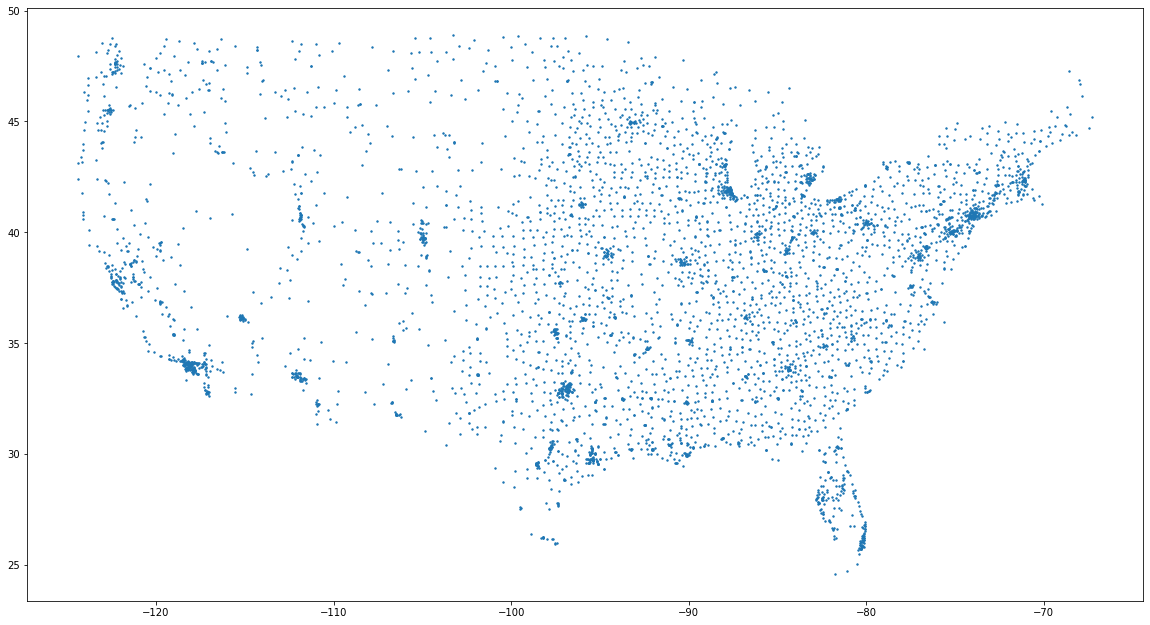

In [16]:
# sanity check on hospital locations... looks correct
hospitals.plot(figsize=(20,20), markersize=2)

## Make the Counties Dataframe

In [17]:
counties_raw = gpd.read_file('../../data/USBoundaryFiles/Counties/cb_2020_us_county_500k/cb_2020_us_county_500k.shp')
counties_raw.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."


In [18]:
# Let's see non-continental counties
print(len(counties_raw['STUSPS'].value_counts()))
counties_raw['STUSPS'].value_counts()

56


TX    254
GA    159
VA    133
KY    120
MO    115
KS    105
IL    102
NC    100
IA     99
TN     95
NE     93
IN     92
OH     88
MN     87
MI     83
MS     82
PR     78
OK     77
AR     75
WI     72
FL     67
AL     67
PA     67
SD     66
LA     64
CO     64
NY     62
CA     58
MT     56
WV     55
ND     53
SC     46
ID     44
WA     39
OR     36
NM     33
AK     30
UT     29
MD     24
WY     23
NJ     21
NV     17
ME     16
AZ     15
MA     14
VT     14
NH     10
CT      8
RI      5
HI      5
AS      5
MP      4
DE      3
VI      3
GU      1
DC      1
Name: STUSPS, dtype: int64

In [19]:
# county plot looks good
counties = counties_raw[~counties_raw['STUSPS'].isin(non_continental_states)][['STATEFP', 'COUNTYFP', 'STATE_NAME', 'NAME', 'ALAND', 'geometry']]
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']
counties = counties.set_index('FIPS')
counties = counties.drop(['STATEFP', 'COUNTYFP'], axis=1)
counties.columns = ['state_name', 'county_name', 'area', 'geometry']
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [20]:
# Sanity check, do we have land area values for all counties?
counties['area'].isna().sum()

# Yes

0

<AxesSubplot:>

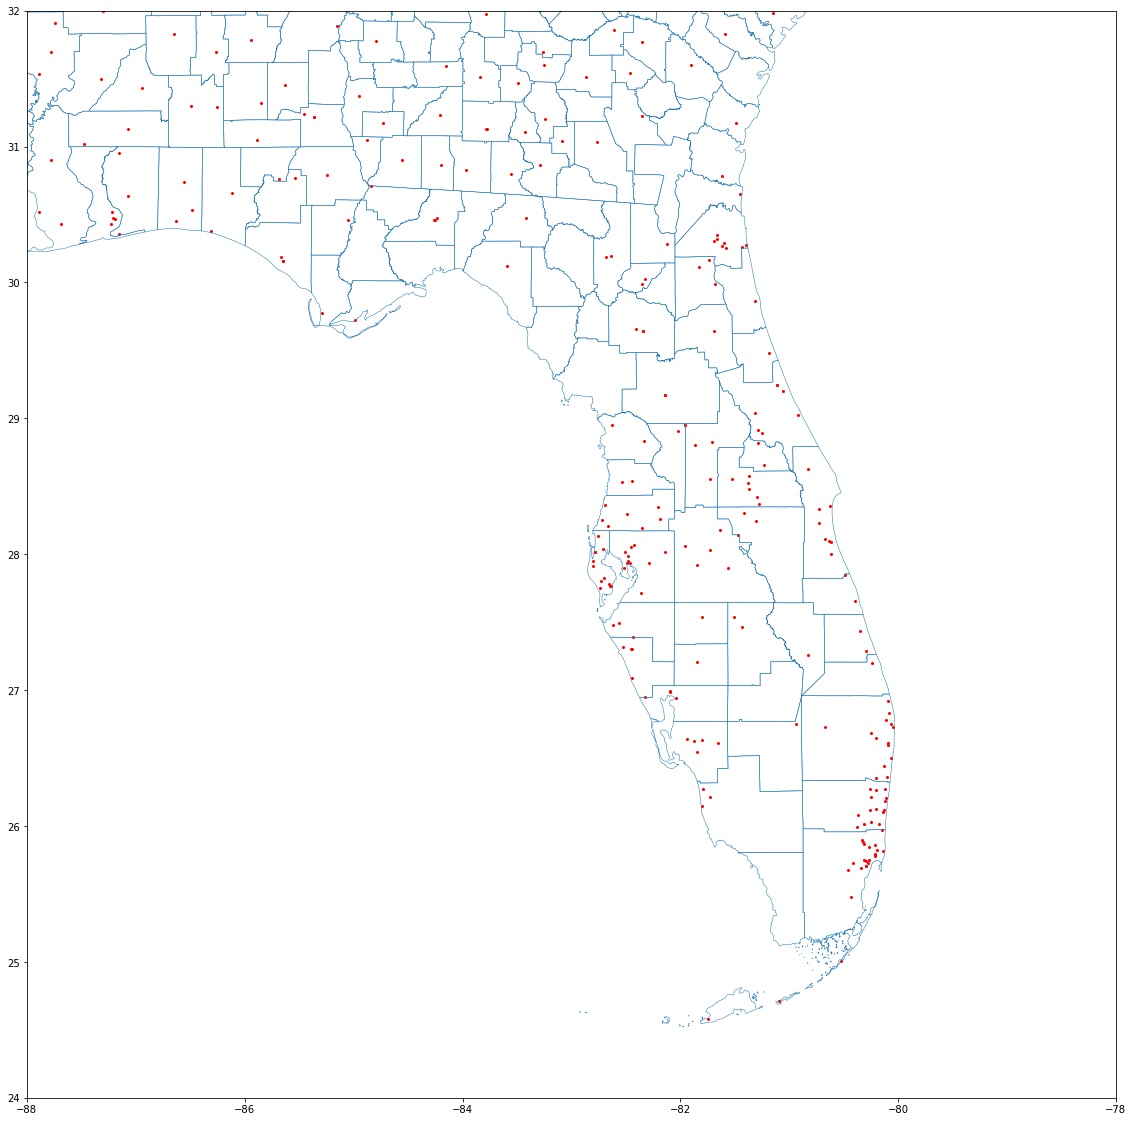

In [21]:
# combining hospital map and counties... can zoom in
# Note: USA bounding box (long, lat): appr. -125 to -65, 25 to 50
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
base.set_xlim([-88, -78])
base.set_ylim([24, 32])
hospitals.plot(markersize=4, color="red", ax=base)

In [22]:
# Let's add the list of hospitals in each county... loop takes a while, O(#counties x #hospitals)
points = hospitals['geometry'].copy()

def get_hospitals(county_geometry):
    global points
    hosps = []
    to_drop = []
    for idx, pt in points.iteritems():
        if pt.within(county_geometry):
            hosps.append(idx)
            to_drop.append(idx)
    points = points.drop(to_drop)
    return hosps

counties['hospitals'] = counties['geometry'].map(get_hospitals)
counties['hospitals']

FIPS
21141                                            [180066]
36081    [330014, 330055, 330128, 330193, 330231, 330395]
34017    [310003, 310016, 310025, 310040, 310074, 310118]
34019                                            [310005]
21147                                                  []
                               ...                       
08014                                            [060129]
08121                                                  []
27037                                    [240059, 240207]
31161                                            [281358]
35037                                            [321302]
Name: hospitals, Length: 3108, dtype: object

In [23]:
# And while we're at it, list each hospital's county (to be added to the hospitals geodataframe)
cs = pd.Series(index=hospitals.index, dtype=str)

for idx, hosps in counties['hospitals'].iteritems():
    for h in hosps:
        cs.loc[h] = idx
    
cs

hospital_pk
010001                                                              01069
010005                                                              01095
010006                                                              01077
010007                                                              01039
010008                                                              01041
                                                                    ...  
ebeac388-7c74-4c9d-9ac6-41d64453c550                                29189
ee04edd185865c38c839812cb2eb5ae5d3f8922e3b629ee98c7d9424a37826c4    22079
f59a354d-92b9-409e-81d3-bef8716d9a79                                48085
f70d7abf93c78280583ac18e896e6737cca8212b017513ffdcf3f4de52d49be4    32003
fa96db24d19f83993a2925454eafc6fa17dd8e64270534ea055da6870010cf58    12125
Length: 4962, dtype: object

In [24]:
# Does each hosptial have a county?
cs[cs.isna()]

# One does not... strange

hospital_pk
452086    NaN
dtype: object

In [25]:
hospitals.loc['452086']

# This is the PAM Specialty Hospital in Corpus Christi, Nueces County, TX

state                                                         TX
hospital_name    POST ACUTE MEDICAL SPECIALTY HOSPITAL CORPUS CH
address                                  345 S WATER ST3RD FLOOR
zip                                                        78401
geometry                                     POINT (-97.39 27.8)
Name: 452086, dtype: object

In [26]:
counties[counties['county_name'] == 'Nueces']

,state_name,county_name,area,geometry,hospitals
FIPS,,,,,
48355,Texas,Nueces,2173169293,"MULTIPOLYGON (((-97.11172 27.89307, -97.10839 ...","[450046, 450788, 453301, 670061]"


<AxesSubplot:>

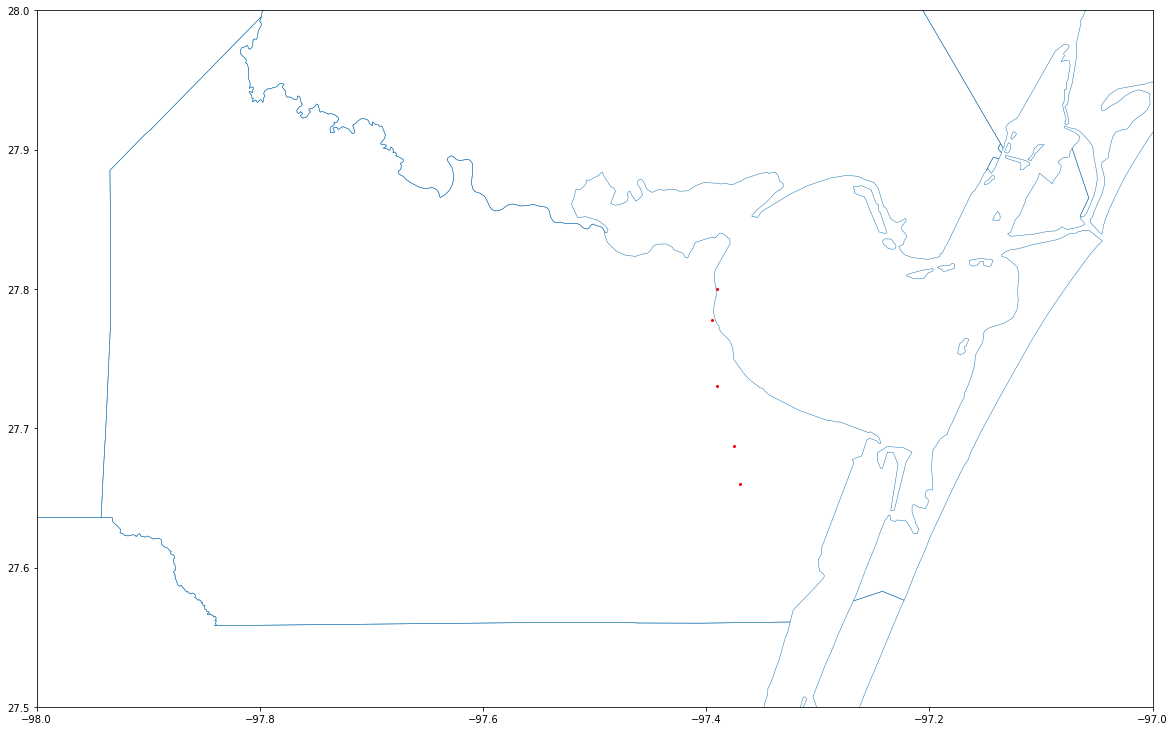

In [27]:
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
base.set_xlim([-98, -97])
base.set_ylim([27.5, 28])
hospitals.plot(markersize=4, color="red", ax=base)

# Ah, it's that top one. It's longitude being rounded to 2 decimal places to -97.39 puts it a few feet into the Gulf of Mexico

In [28]:
# We'll just bump its geomtry west a bit
hospitals.loc['452086', 'geometry'] = Point(-97.40, 27.8)

# Not sure how to react to the warning.

C:\Users\Michael\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [29]:
# Evaluste list of hospitals in each county again
points = hospitals['geometry'].copy()

def get_hospitals(county_geometry):
    global points
    hosps = []
    to_drop = []
    for idx, pt in points.iteritems():
        if pt.within(county_geometry):
            hosps.append(idx)
            to_drop.append(idx)
    points = points.drop(to_drop)
    return hosps

counties['hospitals'] = counties['geometry'].map(get_hospitals)

In [30]:
# And rerun each hospital's county in the hospitals geodataframe
cs = pd.Series(index=hospitals.index, dtype=str)

for idx, hosps in counties['hospitals'].iteritems():
    for h in hosps:
        cs.loc[h] = idx

In [31]:
# Do all hospitals have a county now?
cs[cs.isna()]

# Yes.

Series([], dtype: object)

In [32]:
# Add counties column to hospitals dataframe
hospitals['county'] = cs

C:\Users\Michael\anaconda3\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [33]:
hospitals

,state,hospital_name,address,zip,geometry,county
hospital_pk,,,,,,
010001,AL,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,36301,POINT (-85.36173 31.21406),01069
010005,AL,MARSHALL MEDICAL CENTERS SOUTH CAMPUS,2505 U S HIGHWAY 431 NORTH,35957,POINT (-86.15000 34.20000),01095
010006,AL,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,35630,POINT (-87.65219 34.80276),01077
010007,AL,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,36467,POINT (-86.25541 31.29197),01039
010008,AL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,36049,POINT (-86.26616 31.69260),01041
...,...,...,...,...,...,...
ebeac388-7c74-4c9d-9ac6-41d64453c550,MO,VA St Louis Health Care System - Jefferson Bar...,1 Jefferson Barracks Dr,63125,POINT (-90.28815 38.50153),29189
ee04edd185865c38c839812cb2eb5ae5d3f8922e3b629ee98c7d9424a37826c4,LA,Alexandria Emergency Hospital,5900 Coliseum Blvd,71303,POINT (-92.51048 31.29564),22079
f59a354d-92b9-409e-81d3-bef8716d9a79,TX,Legent Hospital for Special Surgery (FKA Star ...,4100 Mapleshade Ln,75075,POINT (-96.77231 33.00271),48085


In [34]:
hospitals.index.values

array(['010001', '010005', '010006', ...,
       'f59a354d-92b9-409e-81d3-bef8716d9a79',
       'f70d7abf93c78280583ac18e896e6737cca8212b017513ffdcf3f4de52d49be4',
       'fa96db24d19f83993a2925454eafc6fa17dd8e64270534ea055da6870010cf58'],
      dtype=object)

## Save Hospitals DataFrame

In [35]:
if os.path.exists('../../pickles/CDCpickles/hospitals.pkl'):
    os.remove('../../pickles/CDCpickles/hospitals.pkl')
hospitals.to_pickle('../../pickles/CDCpickles/hospitals.pkl')

<AxesSubplot:>

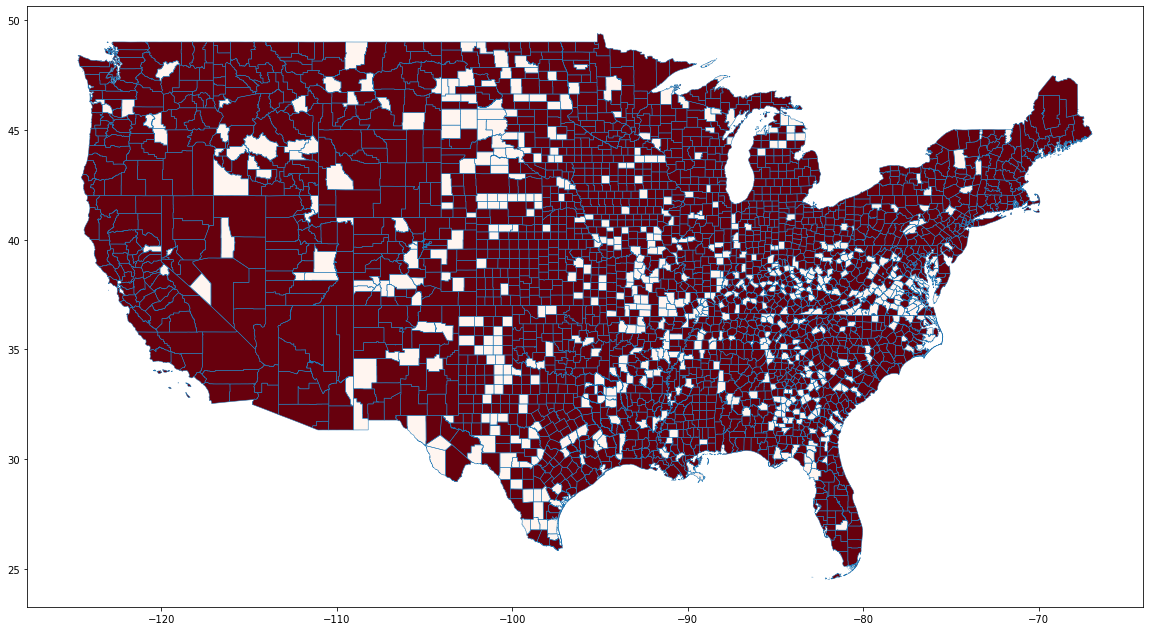

In [36]:
# Choropleth map of hospital counts in each county
# Setting vmax=1 provides a quick view of counties with no hospitals (white ones).
# Note: USA bounding box (long, lat): appr. -125 to -65, 25 to 50
base = counties.boundary.plot(figsize=(20,20), linewidth=0.5)
# base.set_xlim([-85, -73])
# base.set_ylim([36, 42])
counties.plot(column=counties['hospitals'].map(len), cmap='Reds', vmax=1, ax=base)

## Determine adjacent counties

In [37]:
# Sanity check: Are all FIPS correctly constructed with 5 digits?
np.unique(np.vectorize(lambda x: len(x))(counties.index.values), return_counts=True)

# Yes

(array([5]), array([3108], dtype=int64))

In [38]:
# Do any counties "overlap"
counties['temp'] = None
for idx, row in counties.iterrows():
    counties.at[idx, 'temp'] = len(counties[counties.overlaps(row['geometry'])])

print(counties['temp'].value_counts())
counties = counties.drop('temp', axis=1)

# No, so we can determine adjacent counties with only "touches"

0    3108
Name: temp, dtype: int64


In [39]:
counties['neighbors'] = None
for idx, row in counties.iterrows():
    counties.at[idx, 'neighbors'] = counties[counties.touches(row['geometry'])].index.to_numpy()

In [40]:
# We'll also need neighbor's with hospitals
counties['neighbors_wHosp'] = None
for idx, row in counties.iterrows():
    counties.at[idx, 'neighbors_wHosp'] = counties[counties.index.isin(row['neighbors']) & (counties['hospitals'].map(len) > 0)].index.to_numpy()

In [41]:
len(counties.loc['21141', 'neighbors'])

6

In [42]:
counties[counties['county_name'].isin(['Charlottesville'])]

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp
FIPS,,,,,,,
51540,Virginia,Charlottesville,26534611,"POLYGON ((-78.52338 38.02338, -78.52303 38.026...",[490009],[51003],[51003]


In [43]:
# What's the spread of neighbor counts?
counties['neighbors'].map(len).value_counts().sort_index()

0        3
1       21
2       46
3       86
4      291
5      663
6     1065
7      660
8      210
9       49
10      10
11       2
13       1
14       1
Name: neighbors, dtype: int64

In [44]:
# Do the 3 with no neighbors have a hospital?
counties[counties['neighbors'].map(len) == 0][['state_name', 'county_name', 'hospitals']]

# Yes.

,state_name,county_name,hospitals
FIPS,,,
53055,Washington,San Juan,[501340]
25007,Massachusetts,Dukes,[221300]
25019,Massachusetts,Nantucket,[220177]


      state_name county_name
FIPS                        
49037       Utah    San Juan


<AxesSubplot:>

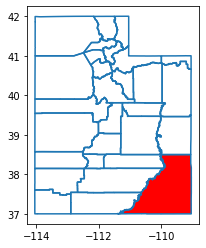

In [45]:
# Curious, what county has 14 neighbors?
friendliest = counties[counties['neighbors'].map(len)==14]
print(friendliest[['state_name', 'county_name']])
base = counties[counties['state_name'].isin(friendliest['state_name'])].boundary.plot()
friendliest.plot(color='red', ax=base)

# San Juan, UT!

In [46]:
# One more thing, is District of Columbia amongst the counties?
counties[counties['state_name'] == 'District of Columbia']

# Yes

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp
FIPS,,,,,,,
11001,District of Columbia,District of Columbia,158316124,"POLYGON ((-77.11976 38.93434, -77.11253 38.940...","[090001, 090003, 090004, 090005, 090008, 09001...","[24031, 24033, 51510, 51013]","[24031, 24033, 51510, 51013]"


## Add population (2019 latest available)

In [47]:
# Hmmm, hopefully this file lists 3108 counties (# of rows in counties file)
pop_raw = pd.read_csv('../../data/USCensus/co-est2019-alldata_trimmed.csv', encoding = 'ISO-8859-1')
print(pop_raw.info(), '\n')
pop_raw

# Nope, 3193, what is the discrepency. Looks like the county names are in the column CITYNAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATE            3193 non-null   int64 
 1   COUNTY           3193 non-null   int64 
 2   STNAME           3193 non-null   object
 3   CTYNAME          3193 non-null   object
 4   POPESTIMATE2019  3193 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 124.9+ KB
None 



,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
0,1,0,Alabama,Alabama,4903185
1,1,1,Alabama,Autauga County,55869
2,1,3,Alabama,Baldwin County,223234
3,1,5,Alabama,Barbour County,24686
4,1,7,Alabama,Bibb County,22394
...,...,...,...,...,...
3188,56,37,Wyoming,Sweetwater County,42343
3189,56,39,Wyoming,Teton County,23464
3190,56,41,Wyoming,Uinta County,20226
3191,56,43,Wyoming,Washakie County,7805


In [48]:
# Ah, there are state roll-up rows. 50, right?
rollups = pop_raw[pop_raw['STNAME'] == pop_raw['CTYNAME']]
print(rollups['STNAME'])

#  No, 52. Ah, but Distict of Columbia is listed twice... and we need to keep one of these.

0                    Alabama
68                    Alaska
98                   Arizona
114                 Arkansas
190               California
249                 Colorado
314              Connecticut
323                 Delaware
327     District of Columbia
328     District of Columbia
329                  Florida
397                  Georgia
557                   Hawaii
563                    Idaho
608                 Illinois
711                  Indiana
804                     Iowa
904                   Kansas
1010                Kentucky
1131               Louisiana
1196                   Maine
1213                Maryland
1238           Massachusetts
1253                Michigan
1337               Minnesota
1425             Mississippi
1508                Missouri
1624                 Montana
1681                Nebraska
1775                  Nevada
1793           New Hampshire
1804              New Jersey
1826              New Mexico
1860                New York
1923          

In [49]:
# Rename one District of Columbia rows to Washington...
pop_raw.loc[328, 'CTYNAME'] = 'Washington'
pop = pop_raw.drop(pop_raw[pop_raw['STNAME'] == pop_raw['CTYNAME']].index)

In [50]:
# Ah, also remove remove Alaska and Hawaii
pop = pop.drop(pop[pop['STNAME'].isin(['Alaska', 'Hawaii'])].index)

In [51]:
# What's county count now?
pop.shape

# 3108, perfect.

(3108, 5)

In [52]:
# Index like counties
# Note: for some reason, set_index changes dtype from string to int... so I change it back (for join to work with counties dataframe)
pop['FIPS'] = pop['STATE'].apply(str).str.zfill(2) + pop['COUNTY'].apply(str).str.zfill(3)
pop.set_index('FIPS', inplace=True)
pop.index = pop.index.astype('str')
pop

,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019
FIPS,,,,,
01001,1,1,Alabama,Autauga County,55869
01003,1,3,Alabama,Baldwin County,223234
01005,1,5,Alabama,Barbour County,24686
01007,1,7,Alabama,Bibb County,22394
01009,1,9,Alabama,Blount County,57826
...,...,...,...,...,...
56037,56,37,Wyoming,Sweetwater County,42343
56039,56,39,Wyoming,Teton County,23464
56041,56,41,Wyoming,Uinta County,20226


In [53]:
counties = counties.join(pop['POPESTIMATE2019']).rename(columns={'POPESTIMATE2019': 'pop'})
counties

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop
FIPS,,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",[180066],"[47147, 21031, 21177, 21227, 21219, 21213]","[47147, 21177, 21227, 21213]",27102
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...","[330014, 330055, 330128, 330193, 330231, 330395]","[36005, 36059, 36061, 36047]","[36005, 36059, 36061, 36047]",2253858
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...","[310003, 310016, 310025, 310040, 310074, 310118]","[34039, 34013, 36061, 34003, 36085]","[34039, 34013, 36061, 34003, 36085]",672391
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",[310005],"[34027, 34041, 34035, 42017, 34021]","[34027, 34041, 34035, 42017, 34021]",124371
21147,Kentucky,McCreary,1105416696,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",[],"[21125, 47013, 47151, 21231, 21199, 21235]","[21125, 47013, 47151, 21231, 21199, 21235]",17231
...,...,...,...,...,...,...,...,...
08014,Colorado,Broomfield,85386686,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",[060129],"[08013, 08059, 08123, 08001]","[08013, 08059, 08123, 08001]",70465
08121,Colorado,Washington,6521806795,"POLYGON ((-103.70655 39.73989, -103.70655 39.7...",[],"[08005, 08001, 08063, 08087, 08125, 08075, 08073]","[08005, 08001, 08063, 08087, 08125, 08075, 08073]",4908
27037,Minnesota,Dakota,1456967786,"POLYGON ((-93.32967 44.77948, -93.32962 44.791...","[240059, 240207]","[27139, 27163, 27053, 55093, 27123, 27131, 27049]","[27139, 27163, 27053, 27123, 27131, 27049]",429021


In [54]:
counties['density'] = counties['pop'] / (counties['area']/1000000)
counties

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",[180066],"[47147, 21031, 21177, 21227, 21219, 21213]","[47147, 21177, 21227, 21213]",27102,18.949479
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...","[330014, 330055, 330128, 330193, 330231, 330395]","[36005, 36059, 36061, 36047]","[36005, 36059, 36061, 36047]",2253858,8003.926219
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...","[310003, 310016, 310025, 310040, 310074, 310118]","[34039, 34013, 36061, 34003, 36085]","[34039, 34013, 36061, 34003, 36085]",672391,5620.080076
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",[310005],"[34027, 34041, 34035, 42017, 34021]","[34027, 34041, 34035, 42017, 34021]",124371,112.239454
21147,Kentucky,McCreary,1105416696,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",[],"[21125, 47013, 47151, 21231, 21199, 21235]","[21125, 47013, 47151, 21231, 21199, 21235]",17231,15.587787
...,...,...,...,...,...,...,...,...,...
08014,Colorado,Broomfield,85386686,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",[060129],"[08013, 08059, 08123, 08001]","[08013, 08059, 08123, 08001]",70465,825.245753
08121,Colorado,Washington,6521806795,"POLYGON ((-103.70655 39.73989, -103.70655 39.7...",[],"[08005, 08001, 08063, 08087, 08125, 08075, 08073]","[08005, 08001, 08063, 08087, 08125, 08075, 08073]",4908,0.752552
27037,Minnesota,Dakota,1456967786,"POLYGON ((-93.32967 44.77948, -93.32962 44.791...","[240059, 240207]","[27139, 27163, 27053, 55093, 27123, 27131, 27049]","[27139, 27163, 27053, 27123, 27131, 27049]",429021,294.461555


In [55]:
# curious
counties.sort_values('density', ascending=False)[:10]

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,
36061,New York,New York,58679457,"MULTIPOLYGON (((-73.99950 40.70033, -73.99750 ...","[330024, 330046, 330100, 330101, 330119, 33015...","[36081, 34017, 36005, 36047, 34003]","[36081, 34017, 36005, 36047, 34003]",1628706,27755.982814
36047,New York,Kings,179684485,"POLYGON ((-74.04201 40.62605, -74.04199 40.626...","[330019, 330056, 330194, 330196, 330201, 33020...","[36081, 36061]","[36081, 36061]",2559903,14246.655742
36005,New York,Bronx,109224611,"MULTIPOLYGON (((-73.77336 40.85945, -73.77244 ...","[330009, 330059, 330080, 330127, 330385, 33039...","[36081, 36119, 36061, 34003]","[36081, 36119, 36061, 34003]",1418207,12984.317243
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...","[330014, 330055, 330128, 330193, 330231, 330395]","[36005, 36059, 36061, 36047]","[36005, 36059, 36061, 36047]",2253858,8003.926219
06075,California,San Francisco,121507089,"MULTIPOLYGON (((-122.33225 37.78207, -122.3322...","[050008, 050047, 050055, 050076, 050152, 05022...","[06001, 06081, 06041]","[06001, 06081, 06041]",881549,7255.124020
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...","[310003, 310016, 310025, 310040, 310074, 310118]","[34039, 34013, 36061, 34003, 36085]","[34039, 34013, 36061, 34003, 36085]",672391,5620.080076
25025,Massachusetts,Suffolk,150876727,"MULTIPOLYGON (((-70.93091 42.32160, -70.93025 ...","[220017, 220031, 220036, 220071, 220075, 22008...","[25017, 25021, 25009]","[25017, 25021, 25009]",803907,5328.237270
42101,Pennsylvania,Philadelphia,347981634,"POLYGON ((-75.28027 39.97496, -75.27648 39.976...","[390025, 390026, 390027, 390111, 390115, 39014...","[42091, 34007, 42045, 42017, 34015, 34005]","[42091, 34007, 42045, 42017, 34005]",1584064,4552.148290
11001,District of Columbia,District of Columbia,158316124,"POLYGON ((-77.11976 38.93434, -77.11253 38.940...","[090001, 090003, 090004, 090005, 090008, 09001...","[24031, 24033, 51510, 51013]","[24031, 24033, 51510, 51013]",705749,4457.846631


<AxesSubplot:>

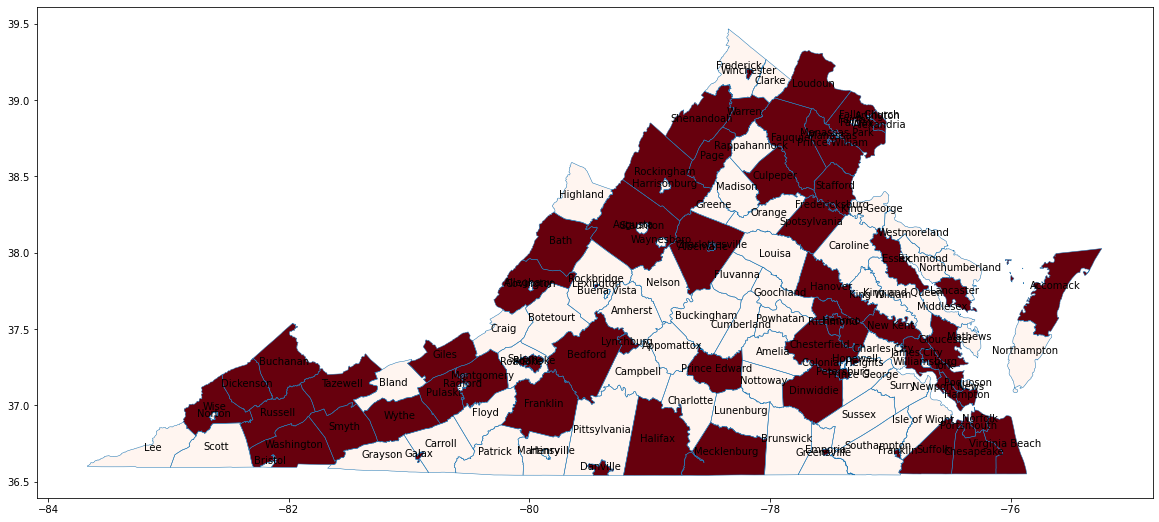

In [56]:
virginia = counties[counties['state_name']=='Virginia']
base = virginia.boundary.plot(figsize=(20,20), linewidth=0.5)
virginia.apply(lambda x: base.annotate(text=x['county_name'], xy=x['geometry'].centroid.coords[0], ha='center'), axis=1)
virginia.plot(column=virginia['hospitals'].map(len), cmap='Reds', vmax=1, ax=base)

## Analyze counties with no hospitals

In [57]:
# How many folks in 2019 lived in a county without a hospital
pop_total = counties['pop'].sum()
pop_noHosp = counties[counties['hospitals'].map(len)==0]['pop'].sum()
print('total 2019 population:', pop_total)
print('population in counties w/out hospitals: ', pop_noHosp, '-->', f'{pop_noHosp/pop_total:.2%}' )

# > 3.5%... will check later the percentage of all reported positive tests that came from these same counties.

total 2019 population: 326092106
population in counties w/out hospitals:  11179596 --> 3.43%


In [58]:
# Do the neighbors of hospital-less countis themselves have hospitals?
# Later we'll want to count hospital-less county positive cases as being treated in neighboring county hospitals (if possible).
counties[counties['hospitals'].map(len)==0]['neighbors_wHosp'].map(len).value_counts().sort_index()

# Almost all have neighboring county hospital

0      3
1     28
2     86
3    139
4    186
5    130
6     80
7     24
8      6
Name: neighbors_wHosp, dtype: int64

In [59]:
# What are those three exceptions?
counties[(counties['hospitals'].map(len)==0) & (counties['neighbors_wHosp'].map(len)==0)]

# Ah, these are Virginia independant towns located in rural counties. I live in Virginia, independent towns are a thing here.
# We'll distribute their reported cases to neighboring counties before distributing those county's cases to their neighbors.

,state_name,county_name,area,geometry,hospitals,neighbors,neighbors_wHosp,pop,density
FIPS,,,,,,,,,
51181,Virginia,Surry,722475752,"POLYGON ((-77.15597 37.11395, -77.13939 37.126...",[],"[51093, 51175, 51036, 51149, 51183]",[],6422,8.888880
51530,Virginia,Buena Vista,16674752,"POLYGON ((-79.38151 37.74215, -79.38027 37.743...",[],[51163],[],6478,388.491535
51690,Virginia,Martinsville,28374648,"POLYGON ((-79.90161 36.68709, -79.89585 36.694...",[],[51089],[],12554,442.437207


In [60]:
if os.path.exists('../../pickles/CDCpickles/counties_plus.pkl'):
    os.remove('../../pickles/CDCpickles/counties_plus.pkl')
counties.to_pickle('../../pickles/CDCpickles/counties_plus.pkl')

In [61]:
counties_base = counties.drop(['hospitals', 'neighbors', 'neighbors_wHosp'], axis=1)
counties_base

,state_name,county_name,area,geometry,pop,density
FIPS,,,,,,
21141,Kentucky,Logan,1430224002,"POLYGON ((-87.06037 36.68085, -87.06002 36.708...",27102,18.949479
36081,New York,Queens,281594050,"POLYGON ((-73.96262 40.73903, -73.96243 40.739...",2253858,8003.926219
34017,New Jersey,Hudson,119640822,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ...",672391,5620.080076
34019,New Jersey,Hunterdon,1108086284,"POLYGON ((-75.19511 40.57969, -75.19466 40.581...",124371,112.239454
21147,Kentucky,McCreary,1105416696,"POLYGON ((-84.77845 36.60329, -84.73068 36.665...",17231,15.587787
...,...,...,...,...,...,...
08014,Colorado,Broomfield,85386686,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",70465,825.245753
08121,Colorado,Washington,6521806795,"POLYGON ((-103.70655 39.73989, -103.70655 39.7...",4908,0.752552
27037,Minnesota,Dakota,1456967786,"POLYGON ((-93.32967 44.77948, -93.32962 44.791...",429021,294.461555


In [62]:
if os.path.exists('../../pickles/counties.pkl'):
    os.remove('../../pickles/counties.pkl')
counties_base.to_pickle('../../pickles/counties.pkl')